## Setup and Configuration

First, let's install the necessary libraries and configure our environment.

In [ ]:
# The SageMaker Studio environment comes with most of these pre-installed.
# This cell ensures all dependencies are present.
# !pip install -q boto3 sagemaker mlflow "scikit-learn>=1.0" "pandas>=1.2"
!pip install -q boto3 sagemaker mlflow "scikit-learn>=1.7" "pandas>=2.3" "matplotlib>=3.10" "numpy>=2.0" "seaborn>=0.13"

In [2]:
import sys
import subprocess

# Ensure MLflow is installed
try:
    import mlflow
    import sagemaker_mlflow
except ImportError:
    print("Installing MLflow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install",  "boto3==1.37.1", "botocore==1.37.1", "s3transfer", "mlflow==2.22.0", "sagemaker-mlflow==0.1.0"])
    import mlflow
    import sagemaker_mlflow

In [ ]:
# import packages
import sagemaker
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import os
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


### Set up Sagemaker session & S3 folder for assignment

In [ ]:
# Setup SageMaker session
sagemaker_session = sagemaker.Session()
sagemaker_client = boto3.client("sagemaker")
s3_client = boto3.client("s3")

# --- IMPORTANT: CONFIGURE THESE VARIABLES ---
s3_bucket = sagemaker_session.default_bucket()
# ----------------------
# UPDATE THESE VARIABLES
bucket_name = 'iti113-team12-bucket'  # e.g., 'my-company-sagemaker-bucket'
base_folder = 'project'      # e.g., 'users/my-name'
# ----------------------

# Define the base path for our datasets
# Scidirect ADL: s3://iti113-team12-bucket/project/datasets/adl/adl/
# Scidirect fall: s3://iti113-team12-bucket/project/datasets/adl/fall/ 
# Dryad C17: s3://iti113-team12-bucket/project/datasets/c17/
data_path_adl = "s3://iti113-team12-bucket/project/datasets/adl/adl/"
data_path_fall = "s3://iti113-team12-bucket/project/datasets/adl/fall/"

print(f"S3 data paths: {data_path_adl}")
print(f"S3 data paths: {data_path_fall}")


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
S3 Bucket: s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment


### Set up tracking server

In [5]:
# Assuming you have your boto3 client and server name
tracking_server_name = "mlflow-server-1234567a"

try:
    response = sagemaker_client.describe_mlflow_tracking_server(
        TrackingServerName=tracking_server_name
    )
    mlflow_tracking_server_arn = response['TrackingServerArn']
    print(f"Found MLflow Tracking Server ARN: {mlflow_tracking_server_arn}")
except Exception as e:
    print(f"Could not find tracking server: {e}")
    mlflow_tracking_server_arn = None

# ARN of your MLflow Tracking Server
# Find this in the SageMaker console or by running `aws sagemaker list-mlflow-tracking-servers`
# mlflow_tracking_server_arn = tracking_server_arn


# IAM role for SageMaker execution
sagemaker_role = sagemaker.get_execution_role()

print(f"SageMaker Role ARN: {sagemaker_role}")
print(f"MLflow Tracking Server ARN: {mlflow_tracking_server_arn}")

Found MLflow Tracking Server ARN: arn:aws:sagemaker:ap-southeast-1:287730026636:mlflow-tracking-server/mlflow-server-1234567a
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
SageMaker Role ARN: arn:aws:iam::287730026636:role/sagemaker-lab-user-8708815v@myaccount.nyp.edu.sg
MLflow Tracking Server ARN: arn:aws:sagemaker:ap-southeast-1:287730026636:mlflow-tracking-server/mlflow-server-1234567a


## Upload assignment dataset

In [6]:
# Define the base path for our datasets
data_path = f"s3://{bucket_name}/{base_folder}/assignment/datasets"

print(f"Your datasets will be versioned inside: {data_path}")

Your datasets will be versioned inside: s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets


In [7]:
# Load dataset
df = pd.read_csv('penguins_size.csv')

# Define S3 path for dataset v1.0 (in case there are edits)
dataset_s3_path_v1 = f"{data_path}/v1.0/penguins_size.csv"
data_v1_s3_uri = os.path.dirname(dataset_s3_path_v1)

# Upload to S3
print(f"Uploading data v1 to {dataset_s3_path_v1}")
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)
s3_client.put_object(Bucket=bucket_name, Key=dataset_s3_path_v1, Body=csv_buffer.getvalue())

print(f"Dataset v1.0 uploaded to: {dataset_s3_path_v1}")

Uploading data v1 to s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v1.0/penguins_size.csv
Dataset v1.0 uploaded to: s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v1.0/penguins_size.csv


In [8]:
# Create version 2

# Define S3 path for dataset v2.0 
dataset_s3_path_v2 = f"{data_path}/v2.0/penguins_size.csv"
data_v2_s3_uri = os.path.dirname(dataset_s3_path_v2)

# Upload to S3
print(f"Uploading data v2 to {dataset_s3_path_v2}")
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)
s3_client.put_object(Bucket=bucket_name, Key=dataset_s3_path_v2, Body=csv_buffer.getvalue())

print(f"Dataset v2.0 uploaded to: {dataset_s3_path_v2}")

Uploading data v2 to s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v2.0/penguins_size.csv
Dataset v2.0 uploaded to: s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v2.0/penguins_size.csv


### Check file exists in S3

In [9]:
def check_file_exists(bucket, key):
    try:
        s3_client.head_object(Bucket=bucket, Key=key)
        print(f"✅ File found: s3://{bucket}/{key}")
        return True
    except s3_client.exceptions.ClientError as e:
        if e.response['Error']['Code'] == '404':
            print(f"❌ File not found: s3://{bucket}/{key}")
            return False
        else:
            raise  # Something else went wrong
            
check_file_exists(bucket_name, dataset_s3_path_v1)
check_file_exists(bucket_name, dataset_s3_path_v2)


✅ File found: s3://sagemaker-iti112-common/s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v1.0/penguins_size.csv
✅ File found: s3://sagemaker-iti112-common/s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v2.0/penguins_size.csv


True

## Read dataset, determine preprocessing steps

In [10]:
try:
    full_data_path_v1 = "s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets/v1.0/penguins_size.csv"
    df_loaded = pd.read_csv(full_data_path_v1)
    print("Successfully loaded dataset v1.0:")
    print(df_loaded.head())
except Exception as e:
    print(f"An error occurred: {e}")
    print("\nPlease double-check that your bucket and folder names are correct in Step 1.")

Successfully loaded dataset v1.0:
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  


In [11]:
for column in df_loaded.columns:
    print(column)
    print(df_loaded[column].unique(),"\n")

species
['Adelie' 'Chinstrap' 'Gentoo'] 

island
['Torgersen' 'Biscoe' 'Dream'] 

culmen_length_mm
[39.1 39.5 40.3  nan 36.7 39.3 38.9 39.2 34.1 42.  37.8 41.1 38.6 34.6
 36.6 38.7 42.5 34.4 46.  37.7 35.9 38.2 38.8 35.3 40.6 40.5 37.9 37.2
 40.9 36.4 42.2 37.6 39.8 36.5 40.8 36.  44.1 37.  39.6 37.5 42.3 40.1
 35.  34.5 41.4 39.  35.7 41.3 41.6 35.5 41.8 33.5 39.7 45.8 42.8 36.2
 42.1 42.9 35.1 37.3 36.3 36.9 38.3 34.  38.1 33.1 43.2 41.  45.6 42.7
 40.2 35.2 41.5 38.5 43.1 36.8 35.6 32.1 40.7 46.5 50.  51.3 45.4 52.7
 45.2 46.1 46.6 51.7 47.  52.  45.9 50.5 50.3 58.  46.4 49.2 42.4 48.5
 50.6 46.7 49.5 52.8 54.2 51.  49.7 47.5 47.6 46.9 53.5 49.  46.2 50.9
 45.5 50.8 50.1 51.5 49.8 48.1 51.4 45.7 50.7 52.2 49.3 50.2 51.9 46.8
 55.8 43.5 49.6 48.7 43.3 48.4 45.1 46.3 44.5 47.8 48.2 47.3 59.6 49.1
 42.6 44.4 44.  45.3 43.6 44.9 45.  43.8 50.4 54.3 47.7 48.6 51.1 52.5
 47.4 43.4 52.1 49.4 55.9 47.2 41.7 53.4 55.1 48.8 49.9] 

culmen_depth_mm
[18.7 17.4 18.   nan 19.3 20.6 17.8 19.6 18.1

In [12]:
# Get rows where sex is '.' to check if typo
filtered_df = df[df['sex'] == '.']
print(filtered_df)

    species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
336  Gentoo  Biscoe              44.5             15.7              217.0   

     body_mass_g sex  
336       4875.0   .  


In [13]:
# Check for class imbalance
df['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

Classes imbalanced - we can't rely on accuracy as the metric since the majority class may get more correct predictions and make it look like the model is accurate, when the minority class may not be well-predicted.

#### To do
In preprocessing:
- Convert '.' in 'sex' column to 'nan'

In preprocessor pipeline:
- Impute nan values
- Encode 'species' (LabelEncoder), 'island', 'sex' (OneHotEncoder)
- Scale 'flipper_length_mm', 'body_mass_g', 'culmen_length_mm', 'culmen_depth_mm' (StandardScaler)

## Create scripts to be used in SageMaker Pipeline

#### 1. Data Cleaning

In [14]:
%%writefile datacleaning.py

import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--input-path', type=str, help="Directory containing penguins_size.csv")
    parser.add_argument("--output-train-path", type=str, help="Output directory for train.csv")
    parser.add_argument("--output-test-path", type=str, help="Output directory for test.csv")
    args = parser.parse_args()

    # Use provided paths or fall back to SageMaker defaults
    input_path = args.input_path
    output_train_path = args.output_train_path
    output_test_path = args.output_test_path

    os.makedirs(output_train_path, exist_ok=True)
    os.makedirs(output_test_path, exist_ok=True)

    # Load data
    input_file = os.path.join(input_path, 'penguins_size.csv')
    print(f"Reading input file from {input_file}...")
    df = pd.read_csv(input_file)

    print("Correcting data inconsistencies...")
    # Replace '.' in 'sex' column with NaN
    df['sex'] = df['sex'].replace('.', pd.NA)

    print("Splitting into train/test...")
    # Stratified train-test split (stratify by species)
    df = df.dropna(subset=['species'])  # can't stratify on NaNs in target
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['species'],
        random_state=42
    )

    # Save splits
    train_output = os.path.join(output_train_path, "train.csv")
    test_output = os.path.join(output_test_path, "test.csv")

    print(f"Saving train to {train_output}")
    train_df.to_csv(train_output, index=False)

    print(f"Saving test to {test_output}")
    test_df.to_csv(test_output, index=False)

    print("Basic data cleaning complete.")


Overwriting datacleaning.py


#### 2. Preprocessor

In [ ]:
%%writefile preprocessor.py

import argparse
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--input-train-path', type=str, help="Previous output directory for train.csv")
    parser.add_argument('--output-train-path', type=str, help="Output directory for processed_train.csv")
    parser.add_argument('--input-test-path', type=str, help="Previous output directory for test.csv")
    parser.add_argument('--output-test-path', type=str, help="Output directory for processed_test.csv")
    args = parser.parse_args()

    input_train_path = args.input_train_path
    output_train_path = args.output_train_path
    input_test_path = args.input_test_path
    output_test_path = args.output_test_path

    # Make output directory
    os.makedirs(output_train_path, exist_ok=True)
    os.makedirs(output_test_path, exist_ok=True)

    # Load train and test data
    input_train = os.path.join(input_train_path, "train.csv")
    if not os.path.exists(input_train):
        raise FileNotFoundError(f"Train data not found: {input_train}")
    print(f"Reading input file from {input_train}...")
    train_df = pd.read_csv(input_train)
    input_test = os.path.join(input_test_path, "test.csv")
    if not os.path.exists(input_test):
        raise FileNotFoundError(f"Test data not found: {input_test}")
    print(f"Reading input file from {input_test}...")
    test_df = pd.read_csv(input_test) # !!!!!

    # ---------------------
    # Imputation
    # ---------------------
    print("Imputing missing data...")
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = ['sex', 'island']  # adjust as needed

    # Numeric imputation
    num_imputer = SimpleImputer(strategy='mean')
    train_df[numeric_cols] = num_imputer.fit_transform(train_df[numeric_cols])
    test_df[numeric_cols] = num_imputer.transform(test_df[numeric_cols])

    # Categorical imputation
    cat_imputer = SimpleImputer(strategy='most_frequent')
    train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
    test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

    # ---------------------
    # Scaling (StandardScaler)
    # ---------------------
    print("Scaling numeric data...")
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    # ---------------------
    # Encoding (OneHot)
    # ---------------------
    print("Encoding categorical data...")
    ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(train_df[categorical_cols])

    ohe_train = pd.DataFrame(ohe.transform(train_df[categorical_cols]),
                             columns=ohe.get_feature_names_out(categorical_cols))
    ohe_test = pd.DataFrame(ohe.transform(test_df[categorical_cols]),
                            columns=ohe.get_feature_names_out(categorical_cols))

    # Drop original categorical columns and join encoded
    print("Finalizing processed train/test data...")
    train_df = train_df.drop(columns=categorical_cols).reset_index(drop=True)
    test_df = test_df.drop(columns=categorical_cols).reset_index(drop=True)
    train_df = pd.concat([train_df, ohe_train], axis=1)
    test_df = pd.concat([test_df, ohe_test], axis=1)

    # Save processed data
    train_output = os.path.join(output_train_path, "train_processed.csv")
    test_output = os.path.join(output_test_path, "test_processed.csv")

    print(f"Saving processed_train to {train_output}")
    train_df.to_csv(train_output, index=False)

    print(f"Saving processed_test to {test_output}")
    test_df.to_csv(test_output, index=False)

    print("Preprocessing complete.")


Overwriting preprocessor.py


#### 3. Training

In [16]:
%%writefile requirements.txt
boto3==1.28.57
botocore==1.31.85

mlflow
sagemaker-mlflow
scikit-learn
pandas
joblib

Overwriting requirements.txt


In [17]:
%%writefile train.py

import sys
import subprocess

# # Ensure MLflow is installed
try:
    import mlflow
    import sagemaker_mlflow
except ImportError:
    print("Installing MLflow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install",  "boto3==1.37.1", "botocore==1.37.1", "s3transfer", "mlflow==2.22.0", "sagemaker-mlflow==0.1.0"])
    import mlflow
    import sagemaker_mlflow
    
# import mlflow
# import sagemaker_mlflow
import mlflow.sklearn
import os
import argparse
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import joblib
import glob

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--tracking-server-arn", type=str, required=True)
    parser.add_argument("--experiment-name", type=str, default="Default")
    parser.add_argument("--model-output-path", type=str, default="/opt/ml/model", help="Output directory for model.joblib")
    parser.add_argument("-C", "--C", type=float, default=0.5)
    parser.add_argument("--penalty", type=str, default="l2")
    parser.add_argument("--class-weight", type=str, default="none")  
    parser.add_argument("--solver", type=str, default="lbfgs")
    args, _ = parser.parse_known_args()

    # Convert string "none" to Python None
    if args.class_weight.lower() == "none":
        class_weight = None
    else:
        class_weight = args.class_weight


    # Make output directory
    model_output_path = args.model_output_path or "/opt/ml/model"
    os.makedirs(model_output_path, exist_ok=True)
    
    # Load training data
    input_train = glob.glob("/opt/ml/input/data/train/train_processed.csv")[0] # first train_processed.csv
    if not os.path.exists(input_train):
        raise FileNotFoundError(f"Processed train data not found: {input_train}")
    df = pd.read_csv(input_train)
    X = df.drop(columns='species')
    y = df['species']

    # Set up MLflow
    mlflow.set_tracking_uri(args.tracking_server_arn)
    print("MLflow tracking URI set successfully.")
    mlflow.set_experiment(args.experiment_name)
    print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")
    print(f"MLflow experiment set to: '{args.experiment_name}'")

    with mlflow.start_run() as run:
        # Log parameters
        mlflow.log_param("C", args.C)
        mlflow.log_param("penalty", args.penalty)
        mlflow.log_param("class_weight", class_weight) #args.class_weight)
        mlflow.log_param("solver", args.solver)
        model = LogisticRegression(
            C=args.C,
            penalty=args.penalty,
            class_weight=class_weight,
            multi_class="multinomial", # using multinomial to optimize all classes together instead of one-vs-rest
            solver=args.solver,
            random_state=42
        )
        model.fit(X, y)
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1_macro = f1_score(y, y_pred, average="macro")
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_macro", f1_macro)
    
        mlflow.sklearn.log_model(sk_model=model, artifact_path="model")
    
        joblib.dump(model, os.path.join(args.model_output_path, "model.joblib"))
        with open(os.path.join(args.model_output_path, "run_id.txt"), "w") as f:
            f.write(run.info.run_id)
    
        print(f"Training complete. Accuracy: {acc:.4f}")
        print(f"MLflow Run ID: {run.info.run_id}")

Overwriting train.py


#### 4. Evaluation

In [18]:
%%writefile evaluate.py
import argparse
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import joblib
import os
import json
import boto3
import tarfile

if __name__ == "__main__":
    # --- Parse Arguments ---
    parser = argparse.ArgumentParser()
    parser.add_argument("--model-path", type=str, required=True, help="Previous output directory for model.joblib.")
    parser.add_argument("--input-test-path", type=str, required=True, help="Previous output directory for test_processed.csv")
    parser.add_argument("--output-path", type=str, required=True, help="Path to save the evaluation.json report.")
    parser.add_argument("--model-package-group-name", type=str, required=True, help="Name of the SageMaker Model Package Group.")
    parser.add_argument("--region", type=str, required=True, help="The AWS region for creating the boto3 client.")
    args = parser.parse_args()

    # --- Extract and Load Model ---
    # SageMaker packages models in a .tar.gz file. We need to extract it first.
    model_archive_path = os.path.join(args.model_path, 'model.tar.gz')
    print(f"Extracting model from archive: {model_archive_path}")
    with tarfile.open(model_archive_path, "r:gz") as tar:
        tar.extractall(path=args.model_path)

    # Load the model using joblib
    model_file_path = os.path.join(args.model_path, "model.joblib")
    if not os.path.exists(model_file_path):
        raise FileNotFoundError(f"Model file 'model.joblib' not found after extraction in: {args.model_path}")
    
    print(f"Loading model from: {model_file_path}")
    model = joblib.load(model_file_path)

    # Load test data
    input_test_path = args.input_test_path
    input_test = os.path.join(input_test_path, "test_processed.csv")
    if not os.path.exists(input_test):
        raise FileNotFoundError(f"Processed test data not found: {input_test}")
    df = pd.read_csv(input_test)
    X_test = df.drop(columns='species')
    y_test = df['species']

    print("Running predictions on the test dataset.")
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average="macro")
    report = {"accuracy": accuracy,
             "f1": f1_macro} # labelled as 'f1' instead of 'f1_macro' in case of change
    print(f"Calculated accuracy: {accuracy:.4f}")
    print(f"Calculated f1_macro: {f1_macro:.4f}")

    # --- Check for Existing Baseline Model in SageMaker Model Registry ---
    print(f"Checking for baseline model in region: {args.region}")
    sagemaker_client = boto3.client("sagemaker", region_name=args.region)
    try:
        response = sagemaker_client.list_model_packages(
            ModelPackageGroupName=args.model_package_group_name, 
            ModelApprovalStatus="Approved", # filter for approved models only
            SortBy="CreationTime",
            SortOrder="Descending",
            MaxResults=1,
        )
        # If the list is not empty, an approved model already exists
        report["baseline_exists"] = len(response["ModelPackageSummaryList"]) > 0 # should include all models regardless of approval status
        if report["baseline_exists"]:
            print(f"An approved baseline model was found in '{args.model_package_group_name}'.")
        else:
             print(f"No approved baseline model was found in '{args.model_package_group_name}'.")

    except sagemaker_client.exceptions.ClientError as e:
        # If the ModelPackageGroup doesn't exist, there is no baseline
        if "ResourceNotFound" in str(e):
            report["baseline_exists"] = False
            print(f"Model Package Group '{args.model_package_group_name}' not found. Assuming no baseline exists.")
        else:
            raise

    # --- Write Final Report ---
    os.makedirs(args.output_path, exist_ok=True)
    report_path = os.path.join(args.output_path, "evaluation.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
        
    print(f"✅ Evaluation complete. Report written to: {report_path}")
    print("Evaluation Report:")
    print(json.dumps(report, indent=4))

Overwriting evaluate.py


## Define the SageMaker Pipeline

#### Pipeline settings & parameters

In [19]:
# Get the role from the current session
sagemaker_role = sagemaker.get_execution_role()

print("Your current SageMaker Execution Role ARN is:")
print(sagemaker_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
Your current SageMaker Execution Role ARN is:
arn:aws:iam::287730026636:role/sagemaker-lab-user-8708815v@myaccount.nyp.edu.sg


In [20]:
# Same as defined above
# data_path = f"s3://{bucket_name}/{base_folder}/assignment/datasets"
print("Verifying data path:")
print(data_path)

Verifying data path:
s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/assignment/datasets


In [21]:
from sagemaker.workflow.parameters import ParameterString, ParameterFloat
from sagemaker.processing import ProcessingInput, ProcessingOutput
import sagemaker

# Get SageMaker role and session
sagemaker_role = sagemaker.get_execution_role()
print(f"Your current SageMaker Execution Role ARN is: {sagemaker_role}")
sagemaker_session = sagemaker.Session()

# Parameters
model_package_group_name = "PenguinModels"
processing_instance_type = "ml.t3.medium"
training_instance_type = "ml.m5.large"
experiment_name_param = ParameterString(name="ExperimentName", default_value="8815v-PenguinPrediction")
accuracy_threshold_param = ParameterFloat(name="AccuracyThreshold", default_value=0.85)
f1_threshold_param = ParameterFloat(name="F1Threshold", default_value = 0.85)


# Hyperparameters
C_param = ParameterFloat(name="C", default_value=0.5)
penalty_param = ParameterString(name="penalty", default_value="l2")
class_weight_param = ParameterString(name="class_weight", default_value="none")
solver_param = ParameterString(name="solver", default_value="lbfgs")

# Define input/output S3 URIs as pipeline parameters
input_data_uri = ParameterString(
    name="InputDataURI", 
    default_value=f"{data_path}/v1.0/penguins_size.csv",  # Default to v1.0
)
train_data_uri = ParameterString(
    name="TrainDataURI", 
    default_value=f"{data_path}/v1.0/preprocessed-data/train" # S3 location
)
test_data_uri = ParameterString(
    name="TestDataURI", 
    default_value=f"{data_path}/v1.0/preprocessed-data/test" 
)
processed_train_data_uri = ParameterString(
    name="ProcessedTrainDataURI", 
    default_value=f"{data_path}/v1.0/preprocessed-data/train"
)
processed_test_data_uri = ParameterString(
    name="ProcessedTestDataURI", 
    default_value=f"{data_path}/v1.0/preprocessed-data/test"
)


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
Your current SageMaker Execution Role ARN is: arn:aws:iam::287730026636:role/sagemaker-lab-user-8708815v@myaccount.nyp.edu.sg
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


#### Define the data cleaning step

In [22]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep

# Define the SKLearnProcessor
datacleaning = SKLearnProcessor(
    framework_version="1.2-1",  
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="cleaning-penguins",
    role=sagemaker_role,
    sagemaker_session=sagemaker_session
)

# Define the data cleaning step
datacleaning_step = ProcessingStep(
    name="CleaningStep",
    processor=datacleaning,
    code="datacleaning.py", # Script was created in previous step
    inputs=[
        ProcessingInput(
            source=input_data_uri,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="output-train-path",
            source="/opt/ml/processing/output/train", # local
            destination=train_data_uri # S3
        ),
        ProcessingOutput(
            output_name="output-test-path",
            source="/opt/ml/processing/output/test", # local
            destination=test_data_uri # S3
        )
    ],
    job_arguments=[
        "--input-path", "/opt/ml/processing/input",
        "--output-train-path", "/opt/ml/processing/output/train",
        "--output-test-path", "/opt/ml/processing/output/test"
    ]
)

#### Define the preprocessing step

In [23]:
# Define the SKLearnProcessor
preprocessing = SKLearnProcessor(
    framework_version="1.2-1",  
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="preprocessing-penguins",
    role=sagemaker_role,
    sagemaker_session=sagemaker_session
)

# Define the processing step
preprocessing_step = ProcessingStep(
    name="PreprocessingStep",
    processor=preprocessing,
    code="preprocessor.py", # Script was created in previous step
    inputs=[
        ProcessingInput(
            input_name="input-train-path",
            source=datacleaning_step.properties.ProcessingOutputConfig.Outputs["output-train-path"].S3Output.S3Uri,
            destination="/opt/ml/processing/input/train"
        ),
        ProcessingInput(
            input_name="input-test-path",
            source=datacleaning_step.properties.ProcessingOutputConfig.Outputs["output-test-path"].S3Output.S3Uri,
            destination="/opt/ml/processing/input/test"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="output-train-path",
            source="/opt/ml/processing/output/train",
            destination=processed_train_data_uri
        ),
        ProcessingOutput(
            output_name="output-test-path",
            source="/opt/ml/processing/output/test",
            destination=processed_test_data_uri
        )
    ],
    job_arguments=[
        "--input-train-path", "/opt/ml/processing/input/train",
        "--input-test-path", "/opt/ml/processing/input/test",
        "--output-train-path", "/opt/ml/processing/output/train",
        "--output-test-path", "/opt/ml/processing/output/test"
    ]
)

#### Define the training step

In [24]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.workflow.steps import TrainingStep, TrainingInput

# Training Step
sklearn_estimator = SKLearn(
    entry_point="train.py", 
    framework_version="1.2-1",
    instance_type=training_instance_type,
    role=sagemaker_role,
    hyperparameters={
        "tracking-server-arn": mlflow_tracking_server_arn,
        "experiment-name": experiment_name_param,
        "model-output-path": "/opt/ml/model", # for saving joblib files locally
        "C": C_param, # used parameter to vary it in pipeline
        "penalty": penalty_param,
        "class-weight": class_weight_param,
        "solver": solver_param
    },
    py_version="py3",
    requirements="requirements.txt" 
)

train_step = TrainingStep(
    name="TrainModel",
    estimator=sklearn_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs["output-train-path"].S3Output.S3Uri,
            content_type="text/csv",
            input_mode="File",  # ensure it's mounted as a file
        )
    },
)

# parser.add_argument("--tracking-server-arn", type=str, required=True)
# parser.add_argument("--experiment-name", type=str, default="Default")
# parser.add_argument('--input-train-path', type=str, help="Previous output directory for train_processed.csv")
# parser.add_argument("--model-output-path", type=str, default="/opt/ml/model", help="Output directory for model.joblib")
# parser.add_argument("-C", "--C", type=float, default=0.5)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


#### Define the Evalution step

In [25]:
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.model_metrics import ModelMetrics, FileSource

evaluation_processor = ScriptProcessor(
    image_uri=sagemaker.image_uris.retrieve("sklearn", sagemaker_session.boto_region_name, "1.2-1"),
    command=['python3'],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="evaluate-model",
    role=sagemaker_role,
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

evaluation_step = ProcessingStep(
    name="EvaluateModel",
    processor=evaluation_processor,
    inputs=[
        ProcessingInput(
            source=train_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=preprocessing_step.properties.ProcessingOutputConfig.Outputs["output-test-path"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation")],
    code="evaluate.py",  # SageMaker will handle uploading and running this script
    job_arguments=[  # Pass arguments here instead of in command
        "--model-path", "/opt/ml/processing/model",
        "--input-test-path", "/opt/ml/processing/test",
        "--output-path", "/opt/ml/processing/evaluation",
        "--model-package-group-name", model_package_group_name,
        "--region", "ap-southeast-1",
    ],
    property_files=[evaluation_report],
    depends_on=[train_step]
)

# parser.add_argument("--model-path", type=str, required=True, help="Previous output directory for model.joblib.")
# parser.add_argument("--input-test-path", type=str, required=True, help="Previous output directory for test_processed.csv")
# parser.add_argument("--output-path", type=str, required=True, help="Path to save the evaluation.json report.")
# parser.add_argument("--model-package-group-name", type=str, required=True, help="Name of the SageMaker Model Package Group.")
# parser.add_argument("--region", type=str, required=True, help="The AWS region for creating the boto3 client.")
    

model_metrics_report = ModelMetrics(
    model_statistics=FileSource(
        s3_uri=evaluation_step.properties.ProcessingOutputConfig.Outputs["evaluation"].S3Output.S3Uri,
        content_type="application/json"
    )
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


#### Define the Model registration step

In [26]:
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.conditions import ConditionNot
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionEquals
from sagemaker.workflow.functions import JsonGet

# RegisterModel step (always defined, but executed conditionally)
step_register_new = RegisterModel(
    name="RegisterNewModel",
    estimator=sklearn_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics_report,
    approval_status="Approved" # changed from "PendingManualApproval" since passed threshold
)

step_register_better_model = RegisterModel(
    name="RegisterBetterModel",
    estimator=sklearn_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics_report,
    approval_status="Approved" # changed from "PendingManualApproval" since passed threshold
)


# Conditions: check accuracy & f1 > threshold OR no model exists
cond_accuracy = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path="accuracy"
    ),
    right=accuracy_threshold_param
)

cond_f1 = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path="f1"
    ),
    right=f1_threshold_param
)

cond_no_registered = ConditionEquals(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path="baseline_exists" # Check the key added to the report
    ),
    right=False # Condition is TRUE if baseline_exists is False
)

# Outer step: Checks for existence of registered model first
step_cond_metrics = ConditionStep(
    name="CheckAccuracyAndF1",
    conditions=[
        cond_accuracy,
        cond_f1,
    ],
    if_steps=[step_register_better_model], # Register model if both metrics pass
    else_steps=[],
)

step_cond_no_registered = ConditionStep(
    name="CheckIfNoModelExists",
    conditions=[cond_no_registered],
    if_steps=[step_register_new], # Register model if no baseline exists
    else_steps=[step_cond_metrics], # If model exists, check accuracy and f1
    depends_on=[evaluation_step]
)





#### Define Pipeline

In [27]:
from sagemaker.workflow.pipeline import Pipeline

# Define the Pipeline
# This assembles our parameters and steps into a single workflow.
pipeline_name = "8815V-Pipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[input_data_uri, 
                train_data_uri,
                test_data_uri,
                processed_train_data_uri,
                processed_test_data_uri,
                experiment_name_param,
                accuracy_threshold_param,
                f1_threshold_param,
                C_param,
                penalty_param,
                class_weight_param,
                solver_param],
    steps=[datacleaning_step,
           preprocessing_step,
           train_step,
           evaluation_step,
           step_cond_no_registered] # Use the 'no registered model' check as the primary condition step
)

# Create or update the pipeline definition in your AWS account.
pipeline.upsert(role_arn=sagemaker_role)

print(f"Pipeline '{pipeline_name}' is defined and ready to be executed.")

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


Pipeline '8815V-Pipeline' is defined and ready to be executed.


## Start Pipeline

In [29]:
from sagemaker.workflow.pipeline import Pipeline

# -------------------------
# Running existing pipeline
# -------------------------
pipeline = Pipeline(name="8815V-Pipeline")
# bucket_name = 'sagemaker-iti112-common'
# base_folder = '8708815v@myaccount.nyp.edu.sg'
# data_path = f"s3://{bucket_name}/{base_folder}/assignment"

# Start the pipeline and pass the S3 path for v1.0 to our parameter
print("\nStarting pipeline execution...")

# Experiment with v1 data
execution_v1 = pipeline.start(
    parameters={
        "InputDataURI": f"{data_path}/v1.0/penguins_size.csv",
        "TrainDataURI": f"{data_path}/v1.0/train",
        "TestDataURI": f"{data_path}/v1.0/test",
        "ProcessedTrainDataURI": f"{data_path}/v1.0/processed/train",
        "ProcessedTestDataURI": f"{data_path}/v1.0/processed/test",
        "C": 0.001,
        "penalty": "l1", # l1 penalty is lasso, can put coefficients to 0
        "class_weight": "balanced", # target is imbalanced
        "solver": "saga" # required for l1 penalty + multinomial
    },
    execution_display_name="exp1-penguins-bad"
)
print(f"--> Execution started! ARN: {execution_v1.arn}")
print(execution_v1.describe())

# Wait for execution_v1 to complete before starting execution_v2
execution_v1.wait()
print("Execution v1 completed.")

if execution_v1.describe()['PipelineExecutionStatus'] == 'Succeeded':
    # Experiment with v2 data
    execution_v2 = pipeline.start(
        parameters={
            "InputDataURI": f"{data_path}/v2.0/penguins_size.csv", # overwrites the defaults above
            "TrainDataURI": f"{data_path}/v2.0/train",
            "TestDataURI": f"{data_path}/v2.0/test",
            "ProcessedTrainDataURI": f"{data_path}/v2.0/processed/train",
            "ProcessedTestDataURI": f"{data_path}/v2.0/processed/test",
            "C": 1.0 # overrides logistic regression C hyperparameter
        }, # solver, penalty and class_weight will use defaults
        execution_display_name="exp1-penguins-good"
    )

    print(f"--> Execution started! ARN: {execution_v2.arn}")
else:
    print("Execution v1 failed, skipping v2.")


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket

Starting pipeline execution...
--> Execution started! ARN: arn:aws:sagemaker:ap-southeast-1:287730026636:pipeline/8815V-Pipeline/execution/8m4z7ptv020y
{'PipelineArn': 'arn:aws:sagemaker:ap-southeast-1:287730026636:pipeline/8815V-Pipeline', 'PipelineExecutionArn': 'arn:aws:sagemaker:ap-southeast-1:287730026636:pipeline/8815V-Pipeline/execution/8m4z7ptv020y', 'PipelineExecutionDisplayName': 'exp1-penguins-bad', 'PipelineExecutionStatus': 'Executing', 'CreationTime': datetime.datetime(2025, 7, 30, 2, 30, 38, 31000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 7, 30, 2, 30, 38, 31000, tzinfo=tzlocal()), 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:ap-southeast-1:287730026636:user-profile/d-yd8hguwiweii/sagemaker-lab-user-8708815v', 'UserProfileName': 'sagemaker-lab-user-8708815v', 'DomainId': 'd-yd8hguwiweii', 'IamIdentity': {'Arn': 'arn:aws:sts::28773002663

In [30]:
sagemaker_client = sagemaker.Session().sagemaker_client

# Get the details of the specific pipeline execution
response = sagemaker_client.describe_pipeline_execution(
    PipelineExecutionArn=execution_v1.arn
)

# Print the current status
status = response['PipelineExecutionStatus']
print(f"Pipeline Status: {status}")

# You can also see the creation time and last modified time
print(f"Creation Time: {response['CreationTime']}")
if 'LastModifiedTime' in response:
    print(f"Last Modified: {response['LastModifiedTime']}")

# Get the details of the specific pipeline execution
response = sagemaker_client.describe_pipeline_execution(
    PipelineExecutionArn=execution_v2.arn
)

# Print the current status
status = response['PipelineExecutionStatus']
print(f"Pipeline Status: {status}")

# You can also see the creation time and last modified time
print(f"Creation Time: {response['CreationTime']}")
if 'LastModifiedTime' in response:
    print(f"Last Modified: {response['LastModifiedTime']}")

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
Pipeline Status: Succeeded
Creation Time: 2025-07-30 02:30:38.031000+00:00
Last Modified: 2025-07-30 02:49:11.783000+00:00
Pipeline Status: Succeeded
Creation Time: 2025-07-30 02:49:41.594000+00:00
Last Modified: 2025-07-30 03:07:53.567000+00:00


## Part 1: SageMaker Experiments

Baseline experiment - hyperparameters & evaluation metrics:
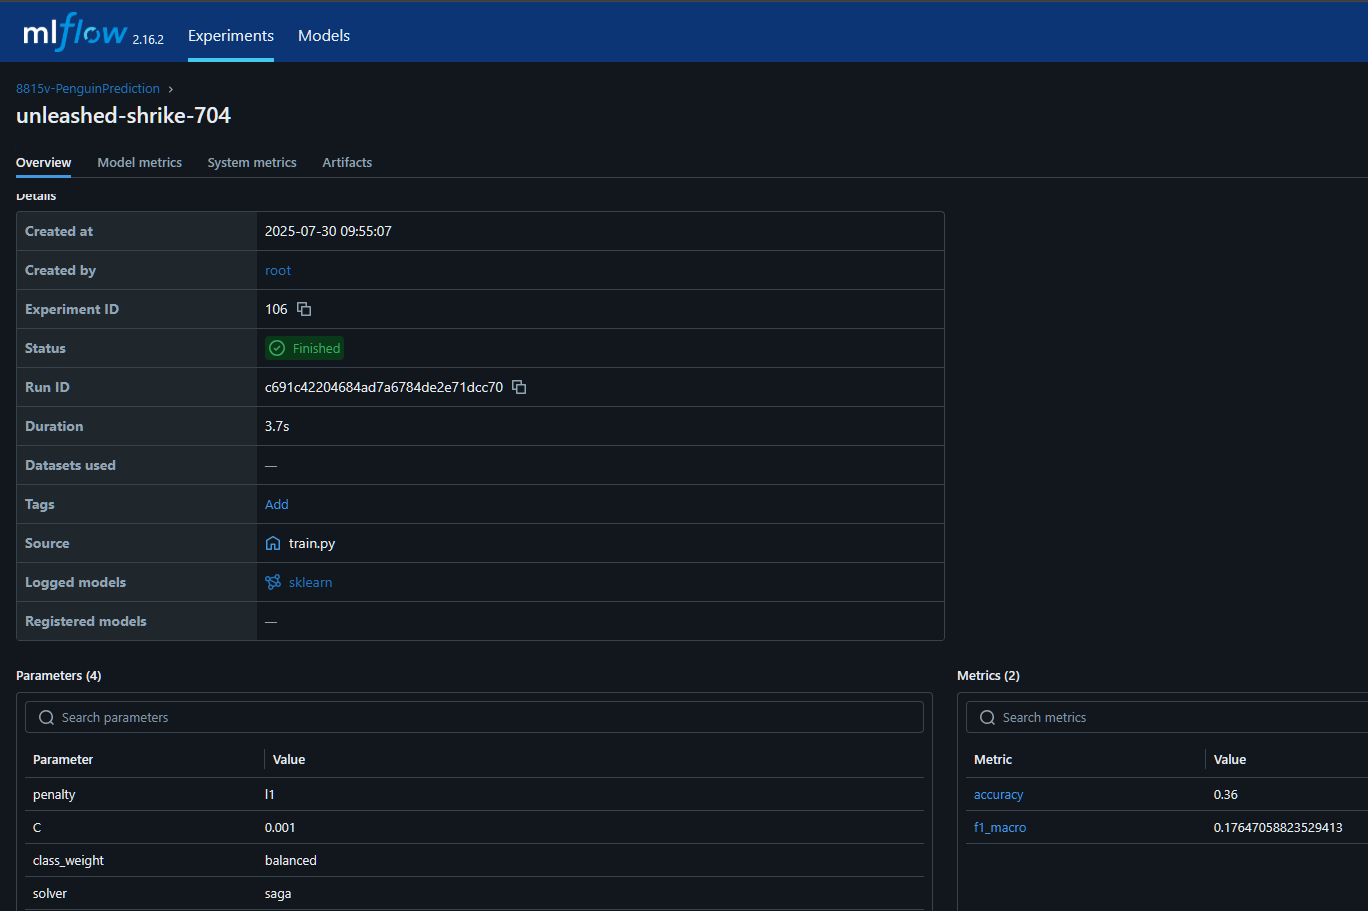

Baseline experiment - model artifacts
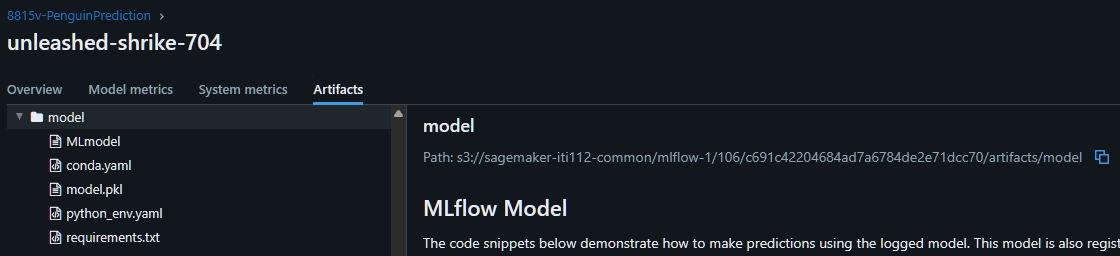

Better experiment - hyperparameters & evaluation metrics:
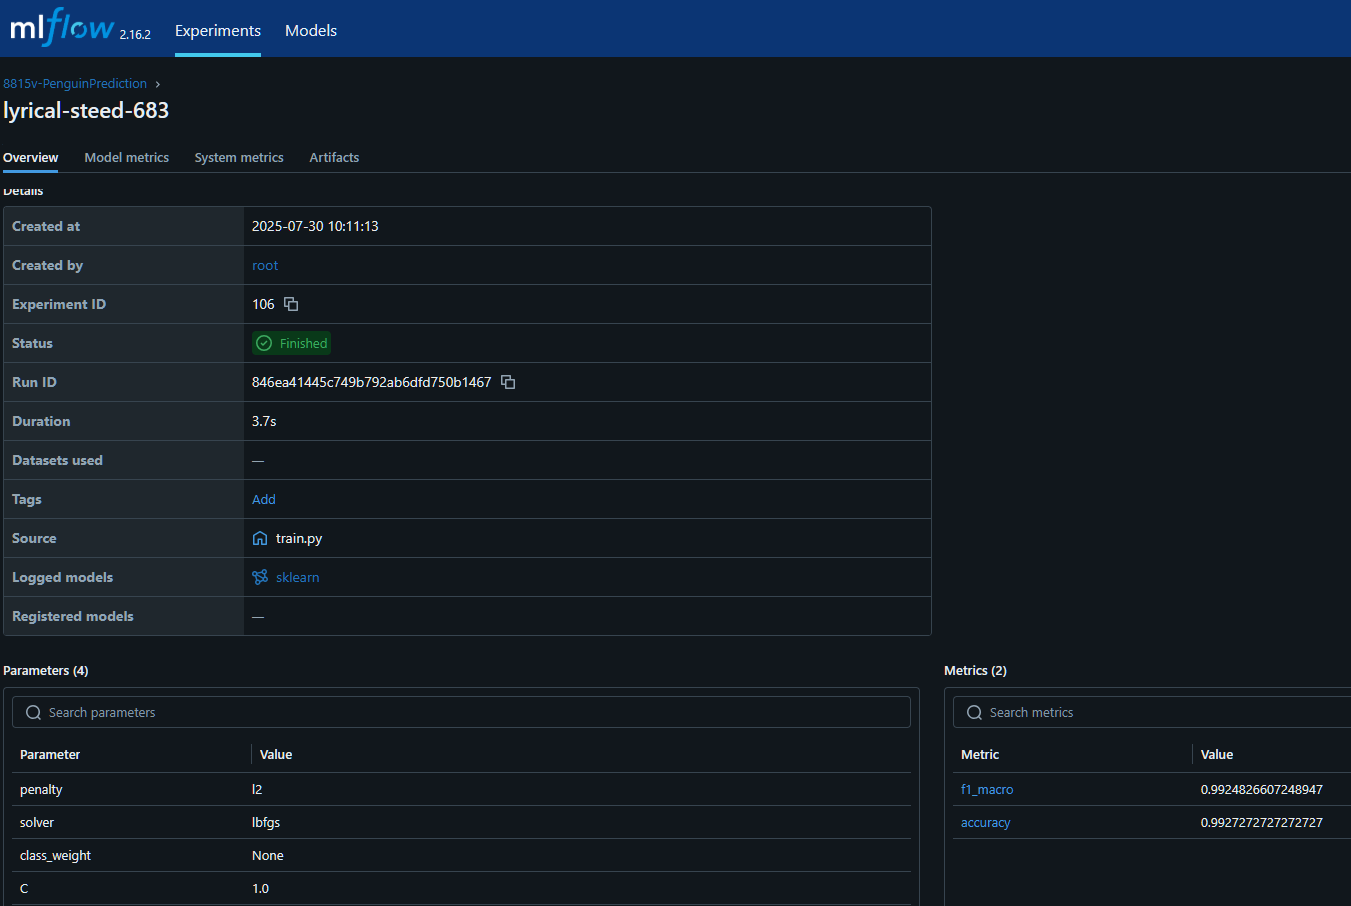

Better experiment - model artifacts
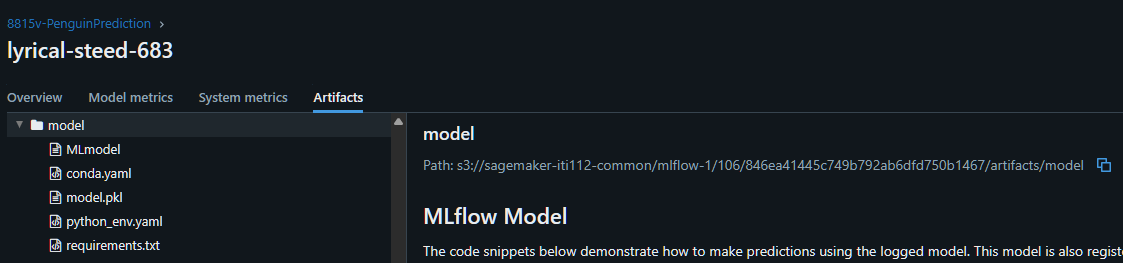

The model from the second experiment was selected for its higher macro F1 score of 0.99, compared to the macro F1 score of 0.17 of the first experiment.

The higher F1 score implies high recall and precision scores, which means that the false negatives and false positives are low.

(Note: the 2 same experiments (with 1 bad & 1 good model) were run twice, with the same input parameters and output metrics. The better model from the later experiment is used for deployment because it is newer.)

## Part 3: SageMaker Pipelines

#### 1st run (no models exist):
Baseline model's pipeline --> no model exists, register baseline without checking metrics
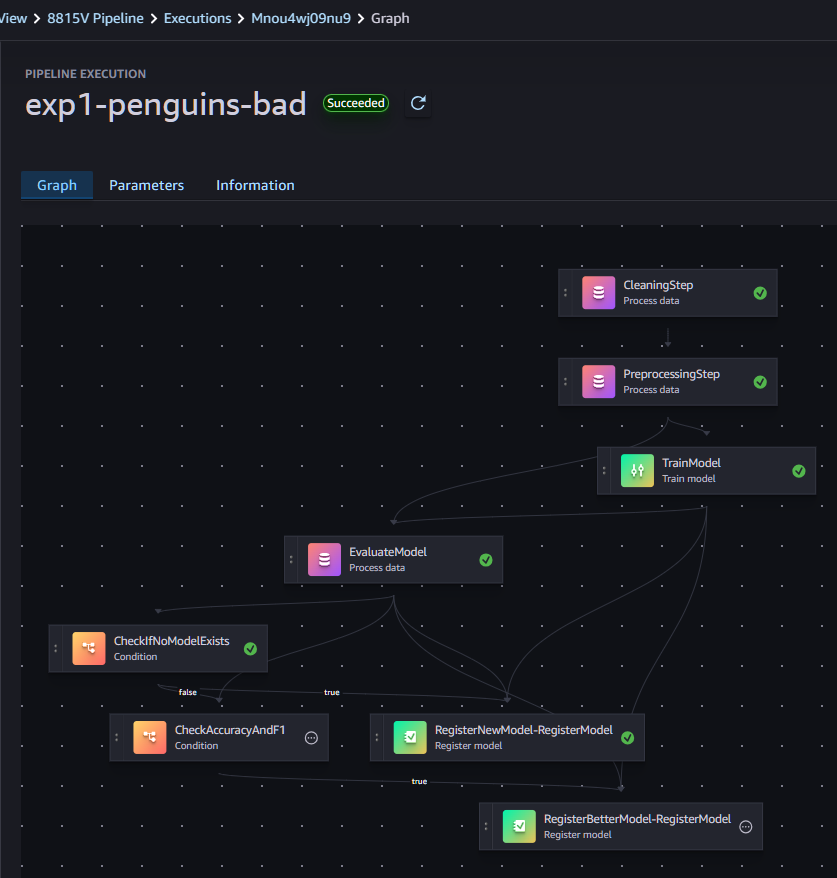

Baseline model's parameters
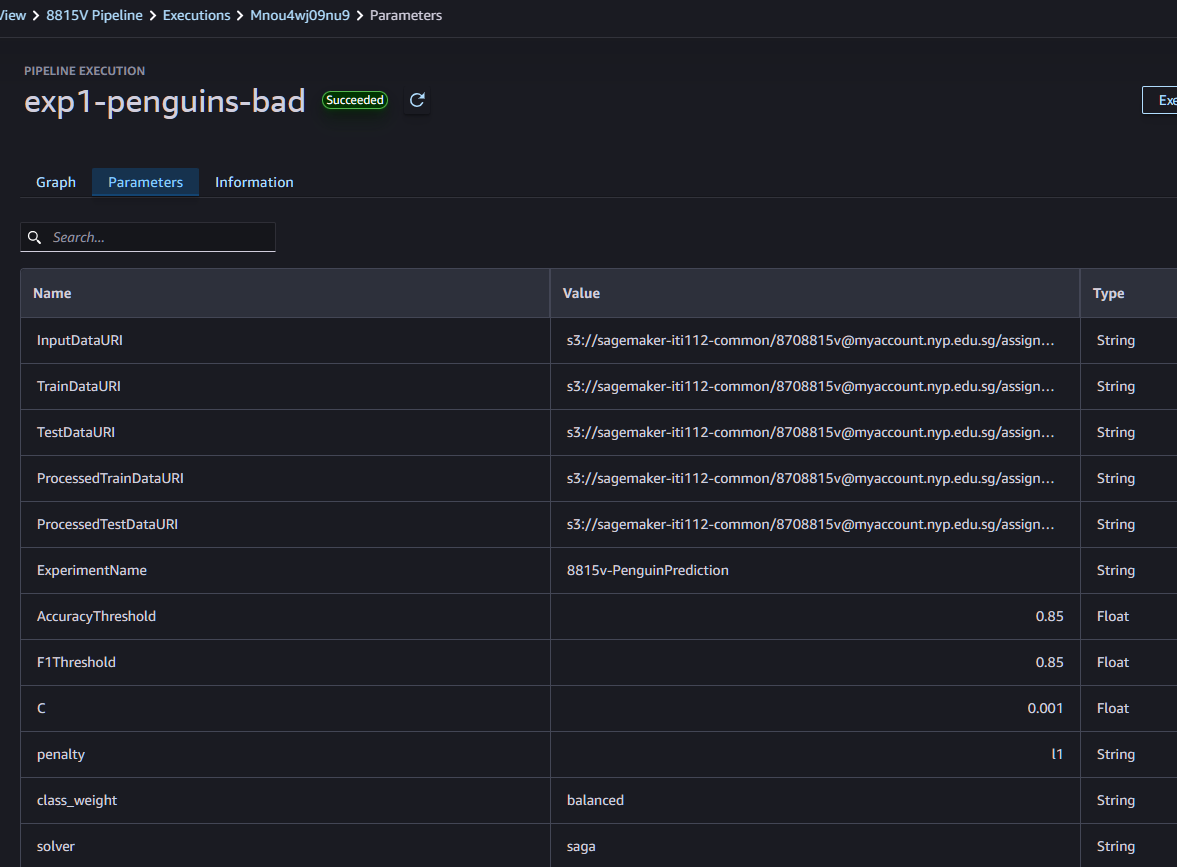

Better model's pipeline --> baseline model exists, register if pass metrics threshold
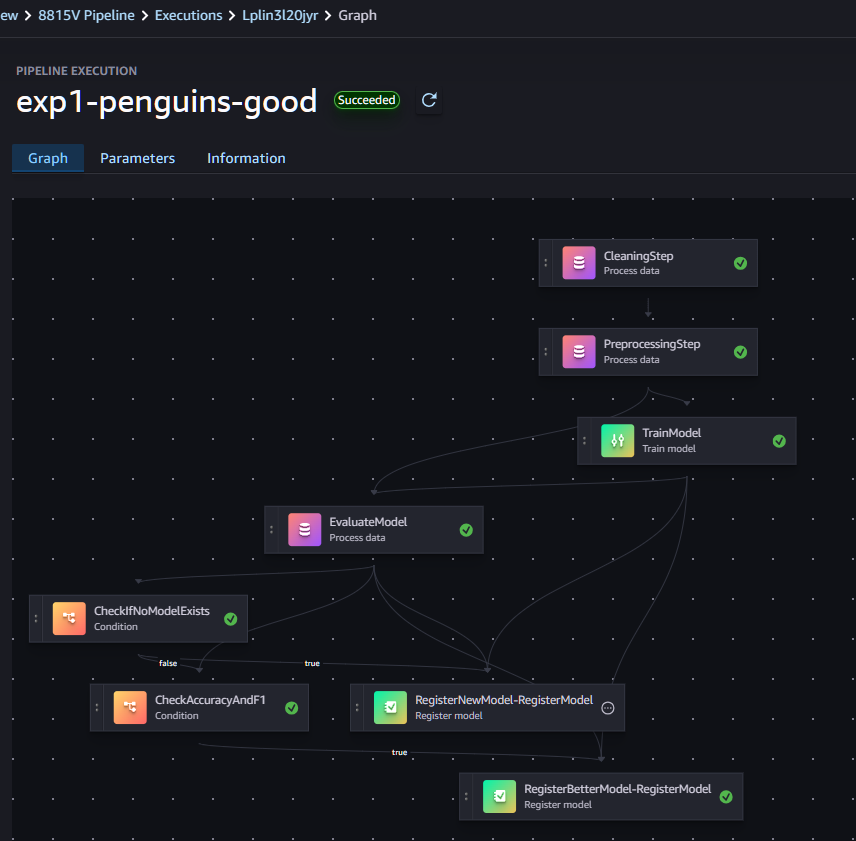

Better model's parameters
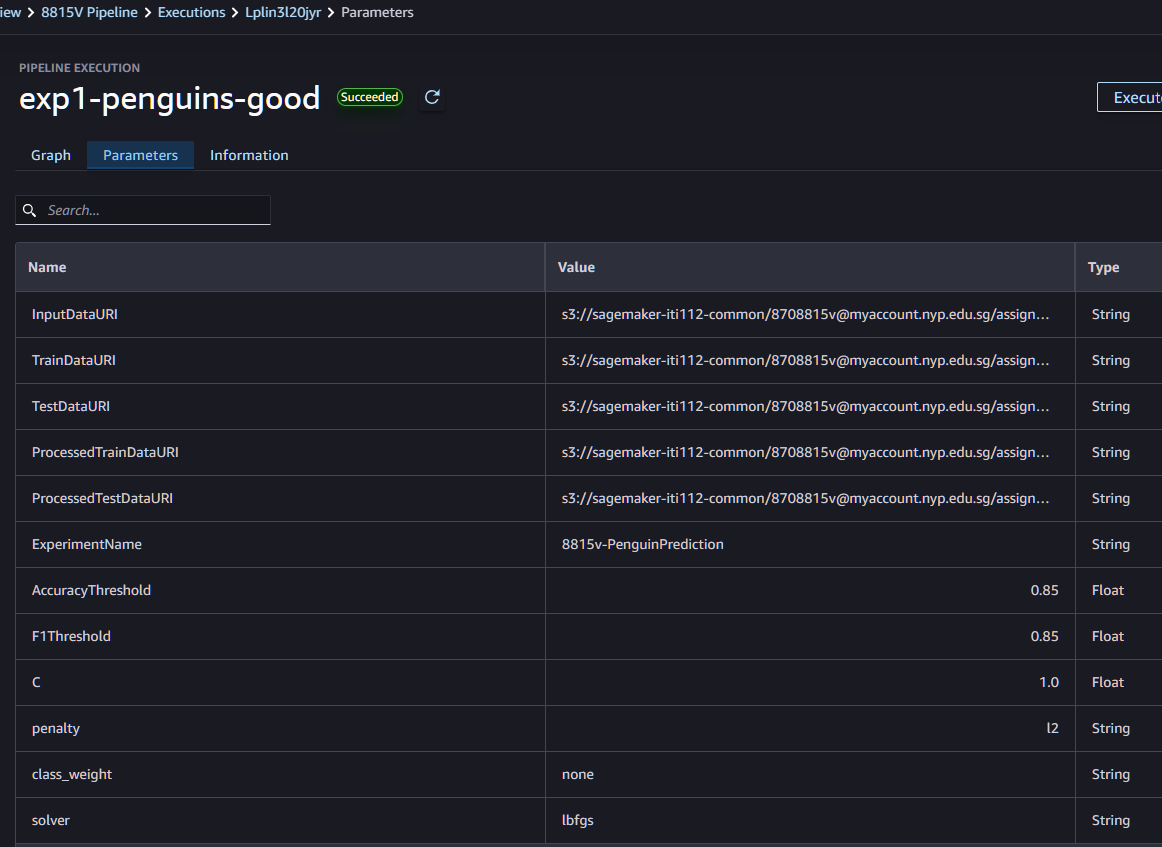

#### 2nd run (models from 1st run exist):
Worse model's pipeline --> baseline model exists, metrics don't pass threshold, no registration
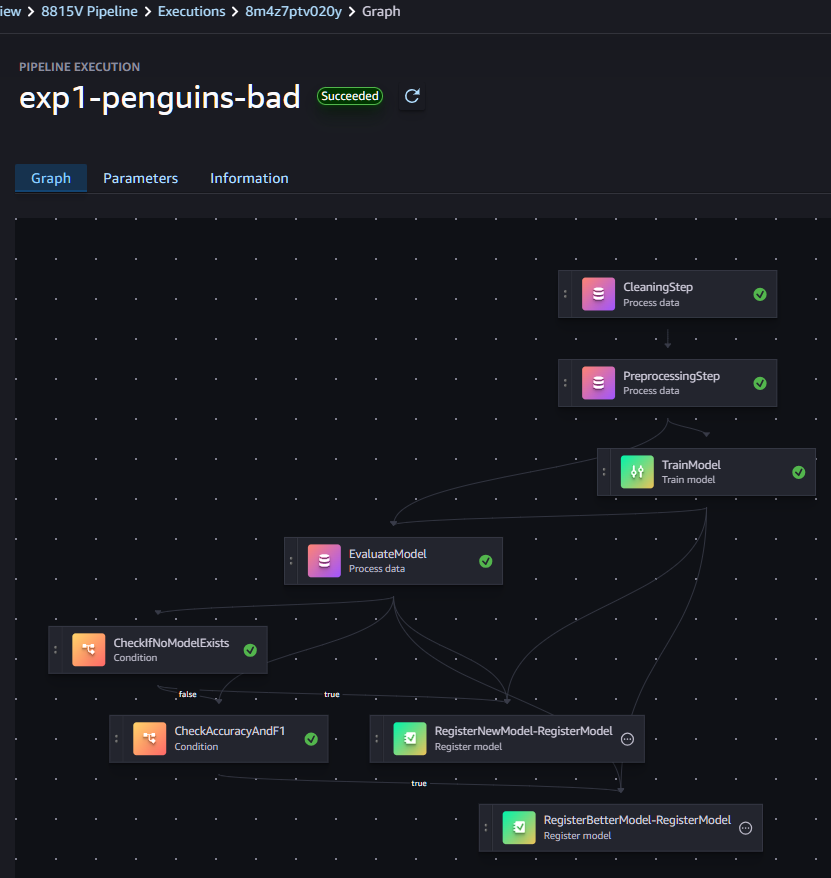

Worse model's parameters
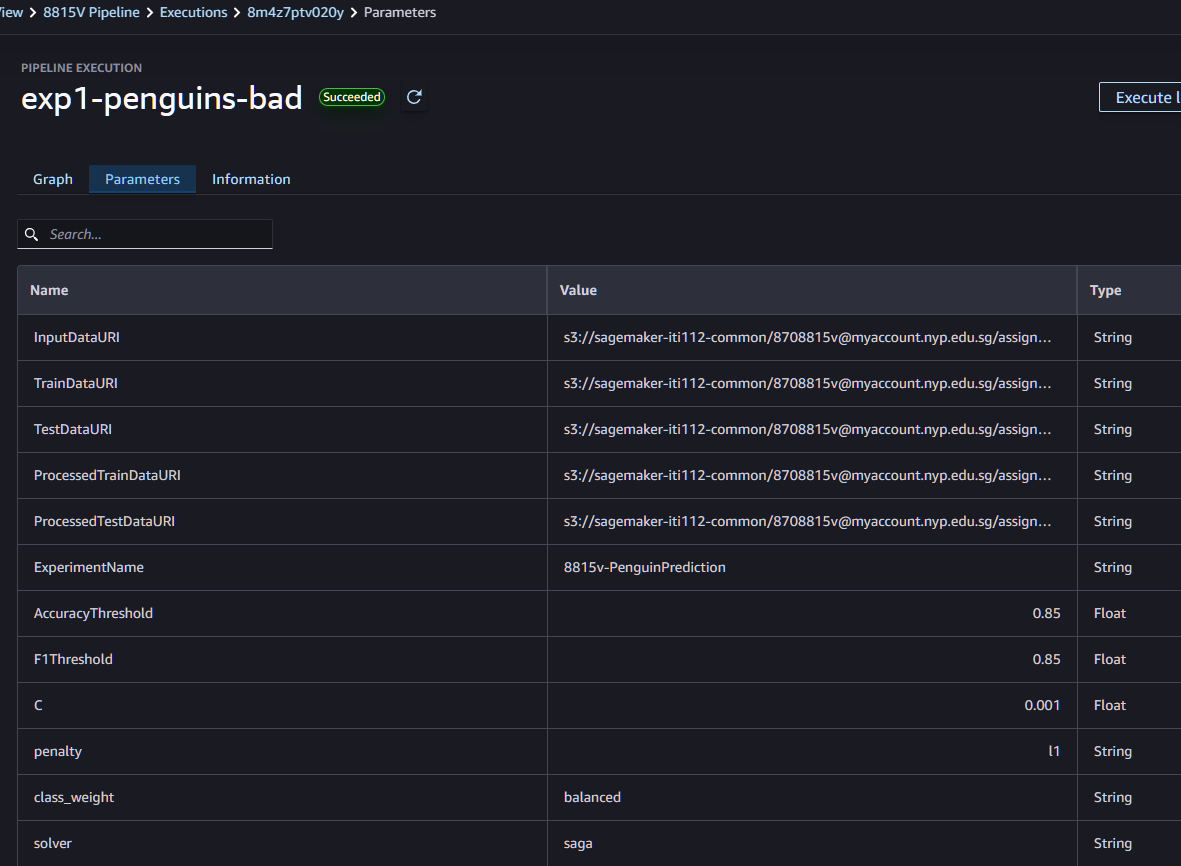

Better model's pipeline --> baseline model exists, register if pass metrics threshold
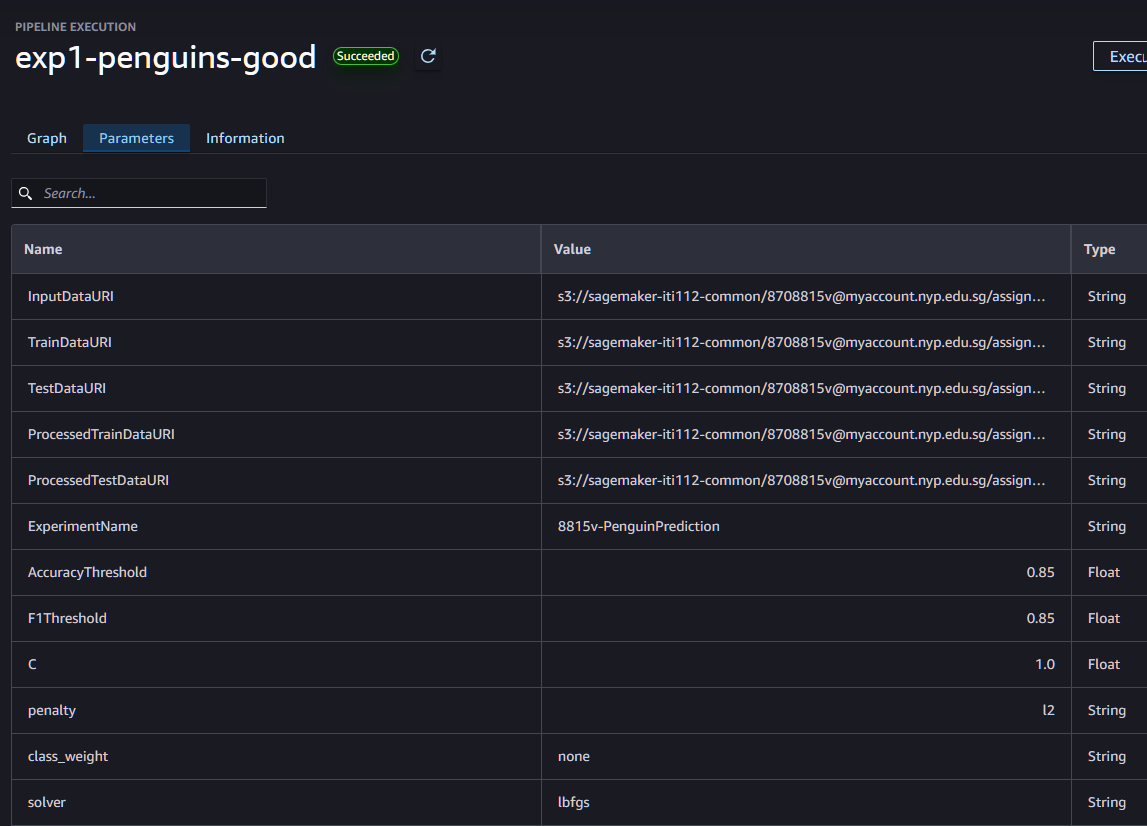

Better model's parameters
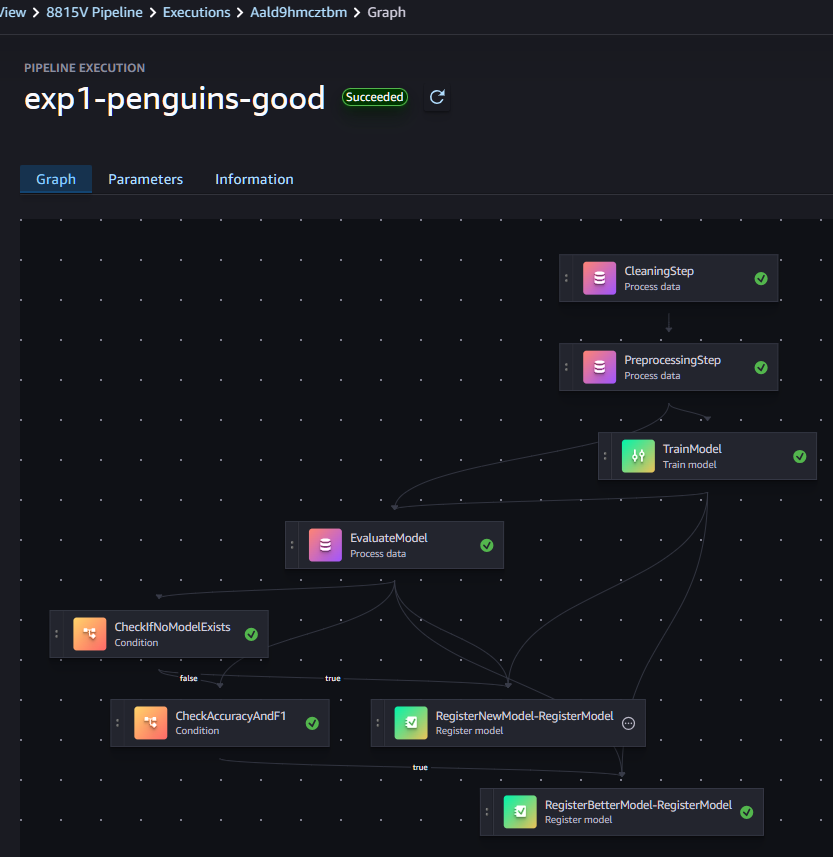

#### Models registered from pipeline runs
From 2 runs of 2 experiments (totalling 4 experiments), 3 models were registered because the bad model did not pass the metrics thresholds:

Baseline model
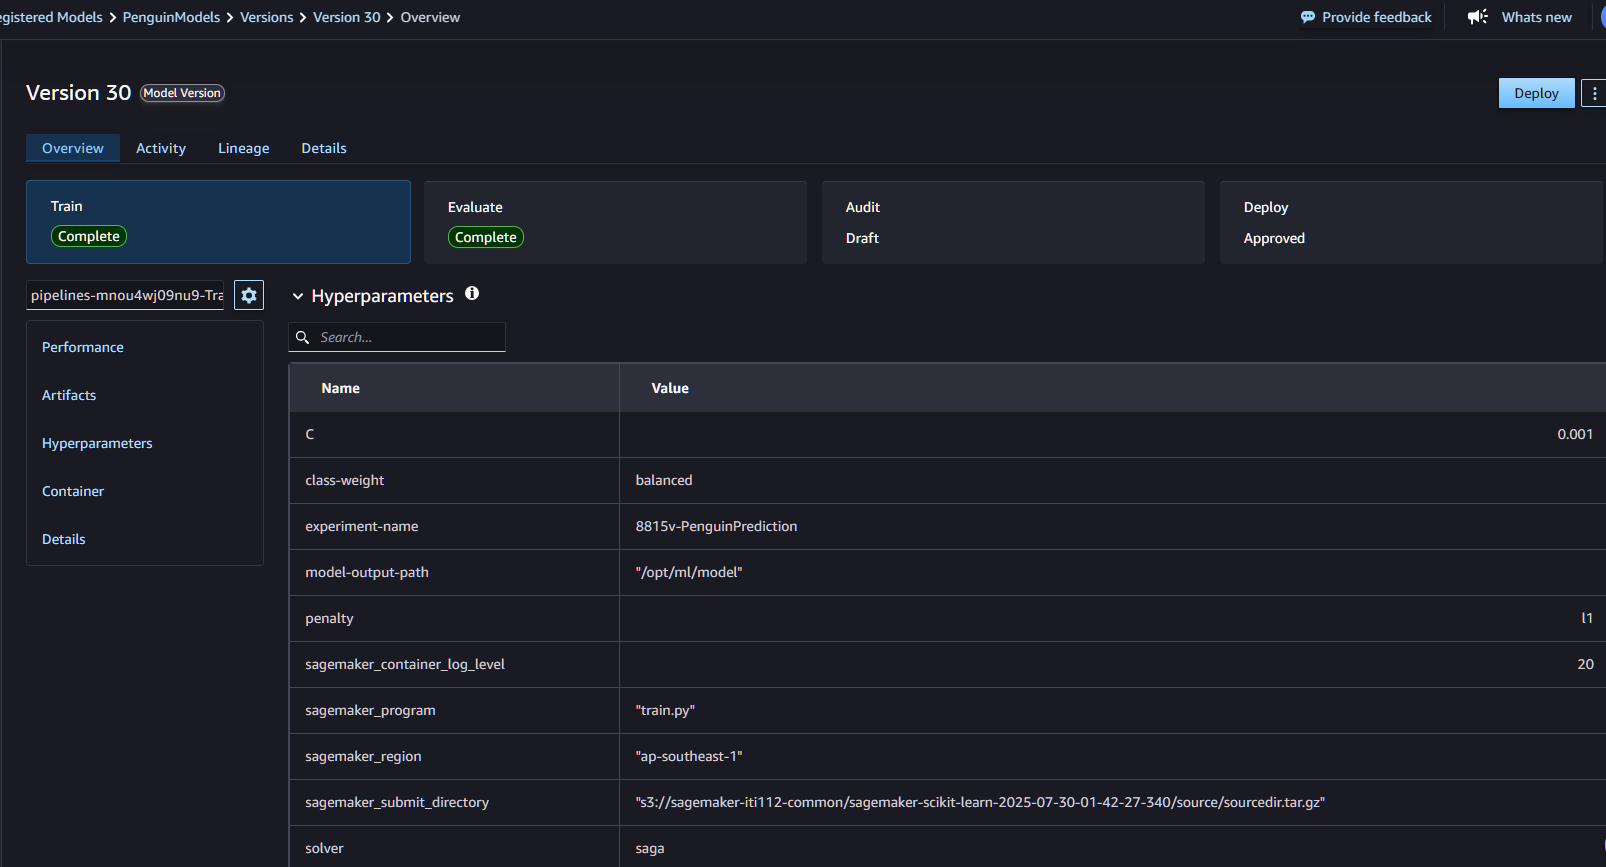

Better model
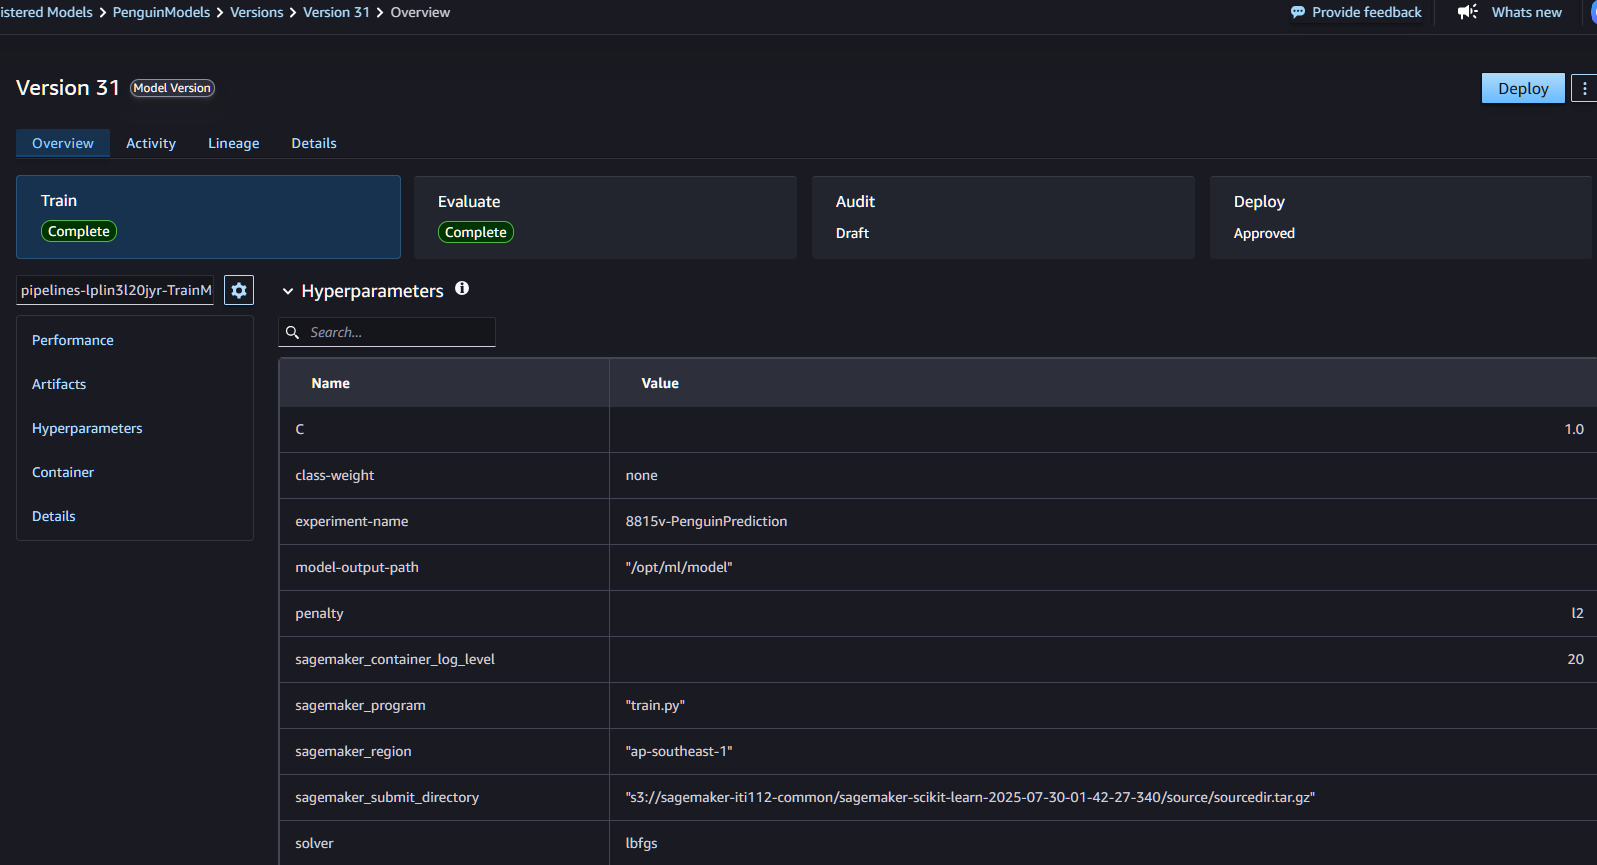

2nd better model that passed metrics thresholds (same parameters as 'better model')
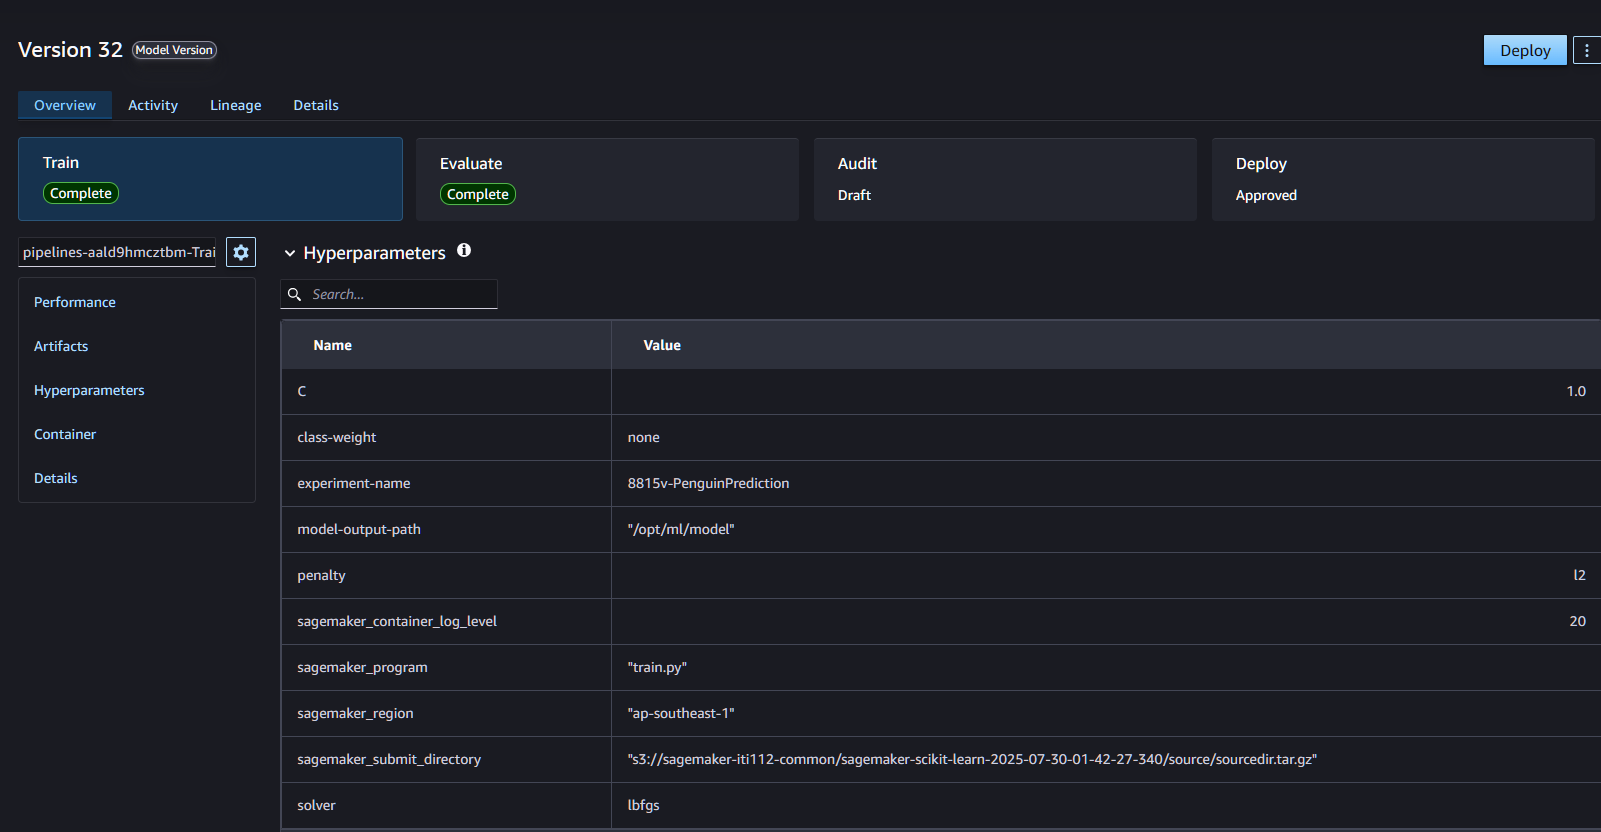


## Manual Deployment

#### 1. Identify best training job

In [31]:
import mlflow

mlflow.set_tracking_uri(mlflow_tracking_server_arn)

experiment = mlflow.get_experiment_by_name("8815v-PenguinPrediction")
runs = mlflow.search_runs(experiment.experiment_id)

print("Experiment:", experiment)

# Find the run with the best metric (e.g., highest f1)
runs = mlflow.search_runs(experiment.experiment_id)
print("Runs type:", type(runs))
# print("Runs columns:", runs.columns)
# print("First few rows:\n", runs.head())

# Check if 'metrics.f1_macro' exists:
if 'metrics.f1_macro' not in runs.columns:
    raise ValueError("No 'metrics.f1_macro' column found. Available metrics:", runs.columns)

best_run = runs.loc[runs['metrics.f1_macro'].idxmax()]
print("Best run:", best_run)

# Construct the model URI from the run
best_run_id = best_run.run_id

model_uri = f"runs:/{best_run_id}/model"
print(f"Registering model from URI: {model_uri}")

# Register the model to the MLflow Model Registry
model_name = "penguin-model-8815v"
registered_model = mlflow.register_model(
    model_uri=model_uri,
    name=model_name
)

print(f"Model '{model_name}' registered with version: {registered_model.version}")

Experiment: <Experiment: artifact_location='s3://sagemaker-iti112-common/mlflow-1/106', creation_time=1753451874748, experiment_id='106', last_update_time=1753451874748, lifecycle_stage='active', name='8815v-PenguinPrediction', tags={}>
Runs type: <class 'pandas.core.frame.DataFrame'>
Best run: run_id                                            e844a036b919434eb7363bf3204d3b7e
experiment_id                                                                  106
status                                                                    FINISHED
artifact_uri                     s3://sagemaker-iti112-common/mlflow-1/106/e844...
start_time                                        2025-07-30 03:02:17.828000+00:00
end_time                                          2025-07-30 03:02:21.510000+00:00
metrics.accuracy                                                          0.992727
metrics.f1_macro                                                          0.992483
params.solver                           

Registered model 'penguin-model-8815v' already exists. Creating a new version of this model...
2025/07/30 03:12:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: penguin-model-8815v, version 7


Model 'penguin-model-8815v' registered with version: 7


Created version '7' of model 'penguin-model-8815v'.


Model version 7 registered from better & newer model source ('clean-grub-770'):
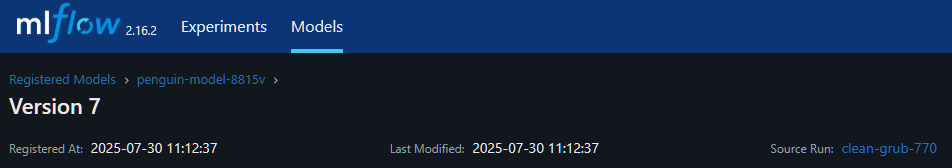

#### 2. Retrieve model artifact from MLflow

In [32]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
model_version = client.get_model_version(model_name, registered_model.version)

model_artifact_s3 = model_version.source
print("Model S3 Artifact URI:", model_artifact_s3)

Model S3 Artifact URI: s3://sagemaker-iti112-common/mlflow-1/106/e844a036b919434eb7363bf3204d3b7e/artifacts/model


#### 3. Download, repackage model, upload

In [33]:
import tarfile
import boto3
import os
import shutil

model_folder = "/tmp/model" # temp local dir
code_folder = os.path.join(model_folder, "code") 
os.makedirs(model_folder, exist_ok=True)

# Download mMLflow artifact to local
mlflow.artifacts.download_artifacts(
    artifact_uri=model_artifact_s3,
    dst_path=model_folder
)

# Find the actual model file inside model_folder (model.pkl)
model_file_path = None
for root, dirs, files in os.walk(model_folder):
    for f in files:
        if f.endswith(".pkl"): 
            model_file_path = os.path.join(root, f)
            break

if not model_file_path:
    raise FileNotFoundError("No model.pkl found in MLflow artifacts")

# Copy it to a clean directory so it's at root level
root_dir = "/tmp/model_root"
os.makedirs(root_dir, exist_ok=True)
shutil.copy(model_file_path, os.path.join(root_dir, "model.pkl"))

# Compress model to model.tar.gz with model.pkl at root
model_tar_path = "/tmp/model.tar.gz"
with tarfile.open(model_tar_path, "w:gz") as tar:
    tar.add(root_dir, arcname=".")

# Upload model.tar.gz to S3
s3 = boto3.client("s3")
bucket_name = sagemaker_session.default_bucket()
# parsed = boto3.session.Session().resource("s3").Bucket(sagemaker_session.default_bucket())
s3_key = f"{base_folder}/models/{model_name}-v{registered_model.version}/model.tar.gz"
s3.upload_file(model_tar_path, bucket_name, s3_key)

model_s3_uri = f"s3://{bucket_name}/{s3_key}"
print("✅ Compressed model uploaded to:", model_s3_uri)

✅ Compressed model uploaded to: s3://sagemaker-iti112-common/8708815v@myaccount.nyp.edu.sg/models/penguin-model-8815v-v7/model.tar.gz


#### 4. Write inference.py file

In [34]:
%%writefile inference.py
# inference.py
import joblib
import os
import pandas as pd

def model_fn(model_dir):
    return joblib.load(os.path.join(model_dir, "model.pkl"))

def input_fn(request_body, content_type):
    if content_type == "application/json":
        return pd.DataFrame.from_dict(eval(request_body))  # simple eval for test input
    raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data, model):
    return model.predict(input_data)

def output_fn(prediction, accept):
    return str(prediction.tolist())

Overwriting inference.py


#### 5. Check model file structure
Make sure model.tar.gz contains model.pkl at the root

In [35]:
import boto3

s3 = boto3.client("s3")
s3_uri = model_s3_uri #"s3://your-bucket/path/to/model.tar.gz"

bucket = s3_uri.replace("s3://", "").split("/")[0]
key = "/".join(s3_uri.replace("s3://", "").split("/")[1:])

local_path = "model.tar.gz"
s3.download_file(bucket, key, local_path)


In [36]:
import tarfile

# Make sure model.tar.gz contains model.pkl at the root
# OR contains MLflow's default format with `MLmodel` + `model.pkl`

with tarfile.open(local_path, "r:gz") as tar:
    tar.list()   # shows file structure


?rwxr-xr-x sagemaker-user/users          0 2025-07-30 03:12:44 ./ 
?rw-r--r-- sagemaker-user/users       1084 2025-07-30 03:12:44 ./model.pkl 


#### 6. Create SageMaker Model object

In [ ]:
from sagemaker.sklearn.model import SKLearnModel

# Create the model object
sklearn_model = SKLearnModel(
    model_data=model_s3_uri,
    role=sagemaker_role,
    entry_point="inference.py", 
    framework_version="1.2-1",
    sagemaker_session=sagemaker_session
)

#### 7. Check and deploy endpoint

In [43]:
from botocore.exceptions import ClientError

# Define the endpoint name
endpoint_name = "8815v-penguin-clf" 
# deleted previous endpoint & endpoint config instead of using {registered_model.version}"


sm_client = boto3.client("sagemaker")
def endpoint_exists(endpoint_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        return True
    except ClientError as e:
        if "Could not find endpoint" in str(e):
            return False
        else:
            raise

if endpoint_exists(endpoint_name):
    predictor = sklearn_model.deploy(
        instance_type="ml.t2.medium",
        initial_instance_count=1,
        endpoint_name=endpoint_name,
        update_endpoint=True # Update endpoint if it already exists
    )
else:
    # Create endpoint if it doesn't exist
    predictor = sklearn_model.deploy(
        instance_type="ml.t2.medium",
        initial_instance_count=1,
        endpoint_name=endpoint_name
    )

print(f"Model deployed at endpoint: {endpoint_name}")

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2025-07-30-03-20-52-727
INFO:sagemaker:Creating endpoint-config with name 8815v-penguin-clf
INFO:sagemaker:Creating endpoint with name 8815v-penguin-clf


-----------!Model deployed at endpoint: 8815v-penguin-clf


## Inference and Cleanup

#### Test endpoint

In [46]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import StringDeserializer

# Create the predictor with JSON handling

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(), # convert to JSON format
    deserializer=StringDeserializer()
)

# Get X_test
processed_test_uri = f"{data_path}/v1.0/processed/test/test_processed.csv"

X_test = pd.read_csv(processed_test_uri)

test_sample = X_test.iloc[:5]
print(test_sample)
# Convert to a dict (records format: {col_name: [v1, v2, ...]})
test_sample = test_sample.drop(columns='species')
payload = test_sample.to_dict(orient="list")

print("Sending payload:\n", payload)

response = predictor.predict(payload)
print("Prediction response:", response)



  species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie         -2.005109        -0.534410          -1.645021    -1.636340   
1  Adelie         -0.816790         1.761560          -0.708965    -0.388429   
2  Adelie         -1.529781        -0.085198          -0.852974    -1.074780   
3  Gentoo          1.084521        -0.634235           1.667176     1.421042   
4  Gentoo          1.066240        -0.534410           0.875129     1.483437   

   sex_MALE  island_Dream  island_Torgersen  
0       0.0           1.0               0.0  
1       0.0           0.0               0.0  
2       0.0           0.0               1.0  
3       1.0           0.0               0.0  
4       1.0           0.0               0.0  
Sending payload:
 {'culmen_length_mm': [-2.0051090117600747, -0.8167896138012701, -1.5297812525765526, 1.0845214229328168, 1.0662395860411429], 'culmen_depth_mm': [-0.5344098100591036, 1.7615595346970407, -0.0851984165198584, -0.63423456417893

## Part 2: SageMaker Endpoints

SageMaker Endpoint ARN:
arn:aws:sagemaker:ap-southeast-1:287730026636:endpoint/8815v-penguin-clf

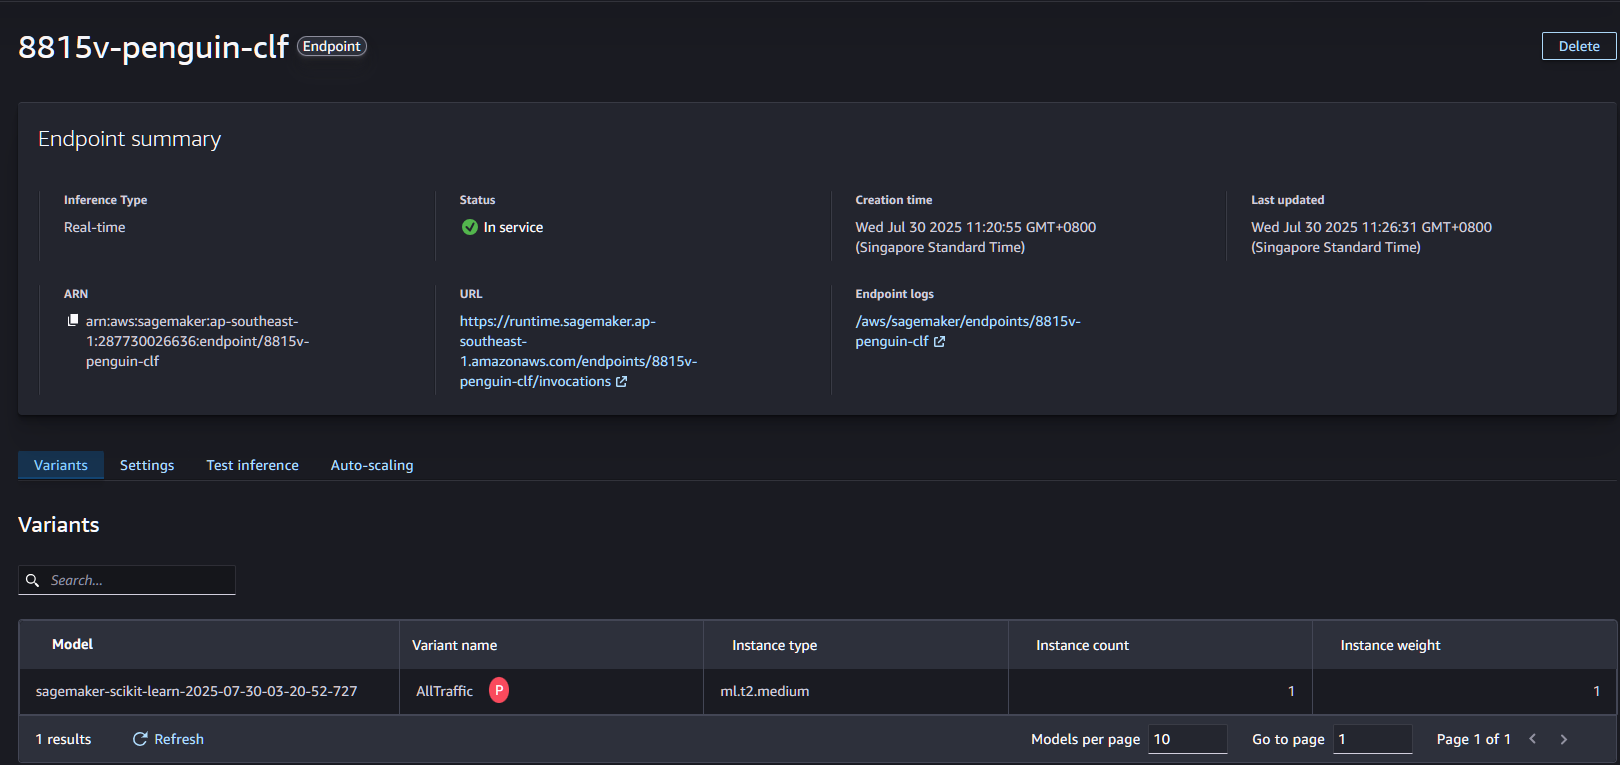

Tested invoking endpoint with sample data, retrieve prediction:
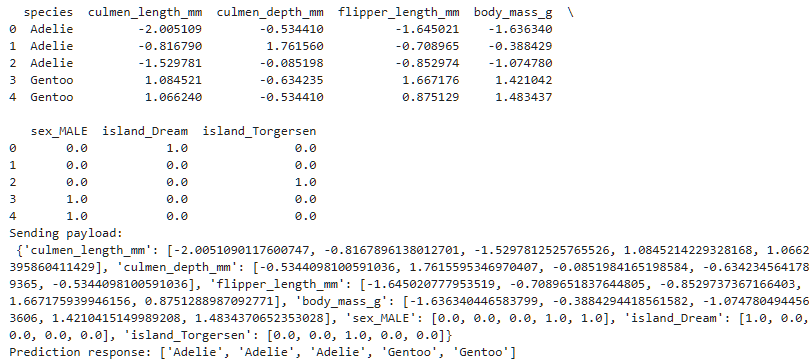

#### View endpoint logs

In [45]:
import boto3

# Enter the name of your SageMaker endpoint
endpoint_name = "8815v-penguin-clf"

# The log group is created based on the endpoint name
log_group_name = f"/aws/sagemaker/Endpoints/{endpoint_name}"

# Create a CloudWatch Logs client
logs_client = boto3.client("logs")

print(f"Searching for logs in: {log_group_name}\n")

try:
    # Find all log streams in the log group, ordered by the most recent
    response = logs_client.describe_log_streams(
        logGroupName=log_group_name,
        orderBy='LastEventTime',
        descending=True
    )

    log_streams = response.get("logStreams", [])

    if not log_streams:
        print("No log streams found. The endpoint might not have processed any requests yet.")
    
    # Loop through each stream and print its recent log events
    for stream in log_streams:
        stream_name = stream['logStreamName']
        print(f"--- Logs from stream: {stream_name} ---")

        # Get log events from the stream
        log_events = logs_client.get_log_events(
            logGroupName=log_group_name,
            logStreamName=stream_name,
            startFromHead=False,  # False gets recent logs first
            limit=50  # Get up to 50 recent log events
        )
        
        # Print events in chronological order
        for event in reversed(log_events.get("events", [])):
            print(event['message'].strip())
        
        print("-" * (len(stream_name) + 24), "\n")

except logs_client.exceptions.ResourceNotFoundException:
    print(f"Error: Log group '{log_group_name}' was not found.")
    print("Please check the endpoint name and ensure it has been invoked.")
except Exception as e:
    print(f"An error occurred: {e}")

Searching for logs in: /aws/sagemaker/Endpoints/8815v-penguin-clf

--- Logs from stream: AllTraffic/i-0ade6cfefcc711c88 ---
169.254.178.2 - - [30/Jul/2025:03:34:51 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:46 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:41 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:36 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:31 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:26 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:21 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:16 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:11 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [30/Jul/2025:03:34:06 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2

#### Delete endpoint

In [42]:
# Clean Up Resources
print(f"Deleting SageMaker endpoint: {endpoint_name}...")
predictor.delete_endpoint()
print("Endpoint deleted successfully.")

from botocore.exceptions import ClientError

try:
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    print(f"Deleted old endpoint config: {endpoint_name}")
except ClientError as e:
    if "Could not find" not in str(e):
        raise


Deleting SageMaker endpoint: 8815v-penguin-clf...
Deleted old endpoint config: 8815v-penguin-clf


## Automated deployment with second pipeline
(Couldn't make the Eventbridge work despite watching for 'model created with approved status' on top of 'model state change to approved status' -  pipeline created but no executions)

#### Deployment script

In [67]:
%%writefile deploy.py
import subprocess
import sys

# --- Install required packages ---
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "boto3==1.28.57", "botocore==1.31.57", "numpy==1.24.1", "sagemaker" ])

# Ensure sagemaker SDK is installed before importing
try:
    import sagemaker
except ImportError:
    print("sagemaker SDK not found. Installing now...")
    install("sagemaker")
    import sagemaker

import argparse
import sagemaker
import boto3
from sagemaker.model import ModelPackage

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    # Accept the registered model's ARN instead of the S3 data path
    parser.add_argument("--model-package-arn", type=str, required=True)
    parser.add_argument("--role", type=str, required=True)
    parser.add_argument("--endpoint-name", type=str, required=True)
    parser.add_argument("--region", type=str, required=True)
    args = parser.parse_args()

    boto_session = boto3.Session(region_name=args.region)
    sagemaker_session = sagemaker.Session(boto_session=boto_session)

    # Create a SageMaker Model object directly from the Model Package ARN
    model = ModelPackage(
        model_package_arn=args.model_package_arn,
        role=args.role,
        sagemaker_session=sagemaker_session,
    )

    # Deploy the model to an endpoint
    print(f"Deploying registered model from ARN to endpoint: {args.endpoint_name}")
    model.deploy(
        initial_instance_count=1,
        instance_type="ml.t2.medium",
        endpoint_name=args.endpoint_name,
        # Update endpoint if it already exists
        update_endpoint=True
    )
    print("Deployment complete.")


Overwriting deploy.py


#### Define deployment pipeline

In [68]:
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.parameters import ParameterString
import sagemaker

# Define Parameters for the deployment pipeline
# This will be provided by the EventBridge trigger
model_package_arn_param = ParameterString(name="ModelPackageArn", default_value="")
role_param = ParameterString(name="ExecutionRole", default_value=sagemaker_role)
endpoint_name_param = ParameterString(name="EndpointName", default_value="8815v-penguin-clf-endpoint")

# Create a ScriptProcessor for deployment
# Using a more recent scikit-learn version is generally a good idea
deploy_processor = ScriptProcessor(
    image_uri=sagemaker.image_uris.retrieve("sklearn", sagemaker_session.boto_region_name, version="1.2-1"),
    command=["python3"],
    instance_type="ml.t3.medium",
    instance_count=1,
    role=role_param,
    base_job_name="deploy-registered-model"
)

# Define the deployment step that takes the model ARN as an argument
step_deploy = ProcessingStep(
    name="DeployRegisteredModel",
    processor=deploy_processor,
    code="deploy.py",
    job_arguments=[
        "--model-package-arn", model_package_arn_param,
        "--role", role_param,
        "--endpoint-name", endpoint_name_param,
        "--region", "ap-southeast-1"
    ]
)



# Define the independent deployment pipeline
deploy_pipeline = Pipeline(
    name="8815V-Deploy",
    parameters=[model_package_arn_param, role_param, endpoint_name_param],
    steps=[step_deploy]
)

# Create or update the pipeline definition
# Capture the response which contains the ARN
response = deploy_pipeline.upsert(role_arn=sagemaker_role)

# Extract the ARN from the response dictionary
pipeline_arn = response['PipelineArn']

print(f"Deployment pipeline ARN: {pipeline_arn}")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket


Deployment pipeline ARN: arn:aws:sagemaker:ap-southeast-1:287730026636:pipeline/8815V-Deploy


#### Eventbridge to watch for event

In [69]:
import boto3
import json

# Initialize the EventBridge client
events_client = boto3.client("events")

# Define the event pattern to listen for
# This pattern triggers when a model package in your group has its status changed to "Approved"
event_pattern = {
    "source": ["aws.sagemaker"],
    "detail-type": [
        "SageMaker Model Package State Change",
        "SageMaker Model Package Created"],
    "detail": {
        "ModelPackageGroupName": [model_package_group_name], 
        "ModelApprovalStatus": ["Approved"]
    }
}

# Define the target for the rule (our deployment pipeline)
# We need to map the event's detail to the pipeline's parameters
target = {
    "Id": "DeployPenguinPipelineTarget",
    "Arn": pipeline_arn, # The ARN of the pipeline we just created
    "RoleArn": sagemaker_role, # The execution role for the pipeline
    "SageMakerPipelineParameters": {
        "PipelineParameterList": [
            {
                # Map the ARN from the event to the pipeline's "ModelPackageArn" parameter
                "Name": "ModelPackageArn",
                "Value": "$.detail.ModelPackageArn"
            }
        ]
    }
}

# Create or update the EventBridge rule
try:
    username_lower = "8708815v@myaccount.nyp.edu.sg".lower().replace("@", "-")
    rule_name = f"{username_lower}-TriggerModelDeploymentOnApproval"
    print(f"Creating or updating EventBridge rule: {rule_name}")
    response = events_client.put_rule(
        Name=rule_name,
        EventPattern=json.dumps(event_pattern),
        State="ENABLED",
        Description="Triggers the SageMaker pipeline to deploy a model upon approval."
    )
    
    # Add the pipeline as a target for the rule
    events_client.put_targets(Rule=rule_name, Targets=[target])
    print("EventBridge rule created successfully!")
    print("Now, when a model is approved in the Model Registry, the deployment pipeline will trigger automatically.")

except Exception as e:
    print(f"Error creating rule: {e}")

Creating or updating EventBridge rule: 8708815v-myaccount.nyp.edu.sg-TriggerModelDeploymentOnApproval
EventBridge rule created successfully!
Now, when a model is approved in the Model Registry, the deployment pipeline will trigger automatically.
